In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import plotly.express as px
from sklearn.cluster import AgglomerativeClustering

In [2]:
file_path = 'dataset/n_itesal.csv'
df = pd.read_csv(file_path, quotechar='"', delimiter=";")
df['STOCK_ACTUAL'] = df['STOCK_ACTUAL'].str.replace(',', '.').astype(float)
df['TOTAL_CANTIDAD_MOVS'] = df['TOTAL_CANTIDAD_MOVS'].str.replace(',', '.').astype(float)
df['PMP'] = df['PMP'].str.replace(',', '.').astype(float)
df['TOTAL_IMPORTE_MOVS'] = df['TOTAL_IMPORTE_MOVS'].str.replace(',', '.').astype(float)
label_encoder = LabelEncoder()
df['ARTICULO'] = label_encoder.fit_transform(df['ARTICULO'])
df['TIPO_MATERIAL'] = label_encoder.fit_transform(df['TIPO_MATERIAL'])
df['CODIGO_FAMILIA'] = label_encoder.fit_transform(df['CODIGO_FAMILIA'])
df.drop(columns=['EMPRESA','PESO_NETO','MULTIPRESENTACION','ARTICULO','CODIGO_FAMILIA'], inplace=True)
columns_to_standardize = ['TIPO_MATERIAL','PMP','STOCK_ACTUAL','TOTAL_CANTIDAD_MOVS','TOTAL_IMPORTE_MOVS','TOTAL_MOVS']
scaler = StandardScaler()
df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

# IQR para detectar y eliminar outliers
columns = columns_to_standardize

filtered_df = df.copy()

for column in columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_df = filtered_df[(filtered_df[column] >= lower_bound) & (filtered_df[column] <= upper_bound)]


original_count = df.shape[0]
filtered_count = filtered_df.shape[0]
reduction = ((original_count - filtered_count) / original_count) * 100

print(f"El DataFrame se ha reducido en un {reduction}%")



El DataFrame se ha reducido en un 34.8635150851748%


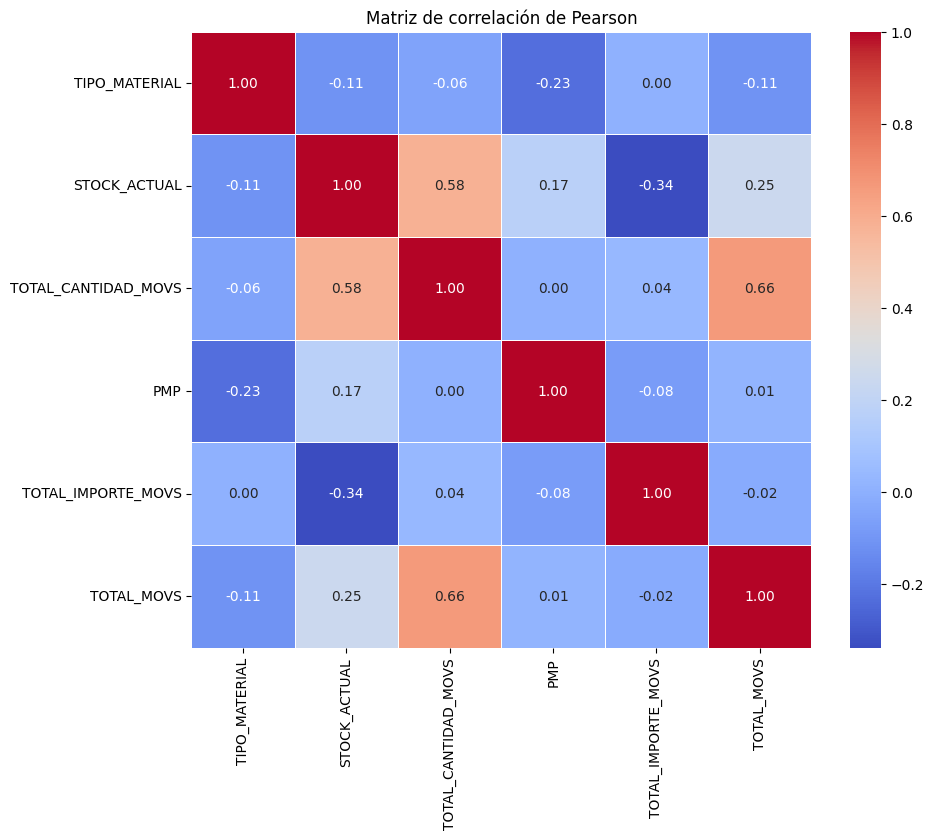

In [3]:
### PON AQUÍ TU CÓDIGO
# Calcula las correlaciones de Pearson entre todas las variables
correlation_matrix = df.corr(method='pearson')

# Configura el tamaño de la figura
plt.figure(figsize=(10, 8))

# Crea un mapa de calor de la matriz de correlaciones
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Añade título
plt.title('Matriz de correlación de Pearson')

# Muestra el mapa de calor
plt.show()

In [4]:
X = df.copy()

In [5]:

# Aplicar Clustering Jerárquico
agg_model = AgglomerativeClustering(n_clusters=3)
y_agg = agg_model.fit_predict(X)

# Agregar etiquetas de cluster al dataframe
clusters_agg = pd.DataFrame(X, columns=X.columns)
clusters_agg['label'] = agg_model.labels_

# Visualización polar para Clustering Jerárquico
polar_agg = clusters_agg.groupby("label").mean().reset_index()
polar_agg = pd.melt(polar_agg, id_vars=["label"])
fig_agg = px.line_polar(polar_agg, r="value", theta="variable", color="label", line_close=True, height=800, width=600)
fig_agg.show()

# Visualización de distribución de clusters con Clustering Jerárquico
pie_agg = clusters_agg.groupby('label').size().reset_index()
pie_agg.columns = ['label', 'value']
px.pie(pie_agg, values='value', names='label').show()

In [6]:
# Calcular métricas de evaluación
silhouette_avg = silhouette_score(X, y_agg)
davies_bouldin_avg = davies_bouldin_score(X, y_agg)

# Imprimir métricas
print("Silhouette Score:", silhouette_avg)
print("Davies-Bouldin Index:", davies_bouldin_avg)
print("")

Silhouette Score: 0.9105635401802622
Davies-Bouldin Index: 0.830991986961481



In [7]:
kmeansmodel = KMeans(n_clusters = 3, init='k-means++', random_state=0,n_init=10)
y_kmeans = kmeansmodel.fit_predict(X)

In [8]:
# Calcular métricas de evaluación
silhouette_avg = silhouette_score(X, y_kmeans)
davies_bouldin_avg = davies_bouldin_score(X, y_kmeans)

# Imprimir métricas
print("Silhouette Score:", silhouette_avg)
print("Davies-Bouldin Index:", davies_bouldin_avg)
print("Innertia:",kmeansmodel.inertia_)

Silhouette Score: 0.9102624445754548
Davies-Bouldin Index: 0.8197213863136228
Innertia: 160192.6051493769


In [ ]:
# Parámetros para DBSCAN
eps_values = np.linspace(0.1, 1.0, 10)
min_samples_values = range(1, 10)
results = []

# Calcular el tamaño mínimo del cluster en base al porcentaje
min_points_percentage = 0.0001  # 5% del total
min_points = int(len(X) * min_points_percentage)

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan_model.fit_predict(X)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Excluir ruido
        
        # Verificar el tamaño mínimo de los clusters
        clusters = pd.Series([label for label in labels if label != -1])
        if all(clusters.value_counts() >= min_points):
            results.append((eps, min_samples, n_clusters))

# Convertir los resultados a un DataFrame
results_df = pd.DataFrame(results, columns=['eps', 'min_samples', 'n_clusters'])
results_pivot = results_df.pivot_table(values='n_clusters', index='eps', columns='min_samples')

# Mostrar la tabla de resultados
print("Resultados del clustering con DBSCAN (número de clusters):")
print(results_pivot)

# Función para encontrar la combinación de parámetros más cercana al número objetivo de clusters
def find_best_dbscan_params(target_clusters, results_df):
    results_df['diff'] = abs(results_df['n_clusters'] - target_clusters)
    best_params = results_df.loc[results_df['diff'].idxmin()]
    return best_params['eps'], int(best_params['min_samples'])

# Especificar el número objetivo de clusters
target_clusters = 5

# Encontrar los mejores parámetros
best_eps, best_min_samples = find_best_dbscan_params(target_clusters, results_df)
print(f"Mejores parámetros para DBSCAN con objetivo de {target_clusters} clusters: eps={best_eps}, min_samples={best_min_samples}")

# Aplicar DBSCAN con los mejores parámetros encontrados
dbscan_model = DBSCAN(eps=best_eps, min_samples=best_min_samples)
y_dbscan = dbscan_model.fit_predict(X)

# Crear un DataFrame para clusters excluyendo el ruido
clusters_dbscan = pd.DataFrame(X, columns=X.columns)
clusters_dbscan['label'] = y_dbscan

# Excluir puntos de ruido
clusters_dbscan_valid = clusters_dbscan[clusters_dbscan['label'] != -1]

# Calcular las medias de las features para cada cluster
cluster_means = clusters_dbscan_valid.groupby('label').mean()

# Calcular la media global
global_mean = clusters_dbscan_valid.mean()

# Comparar las medias de cada cluster con la media global
influence = cluster_means - global_mean

# Mostrar la influencia de cada feature en cada cluster
print("Influencia de las features en cada cluster:")
print(influence)

# Visualización de la influencia de las features en cada cluster
plt.figure(figsize=(12, 8))
sns.heatmap(influence, annot=True, cmap='coolwarm')
plt.title('Influencia de las features en cada cluster')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Supongamos que X es tu conjunto de datos
X = StandardScaler().fit_transform(X)

# Parámetros para DBSCAN
eps_values = np.linspace(0.1, 1.0, 10)
min_samples_values = range(1, 10)
results = []

# Calcular el tamaño mínimo del cluster en base al porcentaje
min_points_percentage = 0.01  # 1% del total
min_points = int(len(X) * min_points_percentage)

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan_model.fit_predict(X)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Excluir ruido
        
        # Verificar el tamaño mínimo de los clusters
        clusters = pd.Series([label for label in labels if label != -1])
        if not clusters.empty and all(clusters.value_counts() >= min_points):
            results.append((eps, min_samples, n_clusters))

# Convertir los resultados a un DataFrame
results_df = pd.DataFrame(results, columns=['eps', 'min_samples', 'n_clusters'])

if not results_df.empty:
    results_pivot = results_df.pivot_table(values='n_clusters', index='eps', columns='min_samples')

    # Mostrar la tabla de resultados
    print("Resultados del clustering con DBSCAN (número de clusters):")
    print(results_pivot)

    # Función para encontrar la combinación de parámetros más cercana al número objetivo de clusters
    def find_best_dbscan_params(target_clusters, results_df):
        results_df['diff'] = abs(results_df['n_clusters'] - target_clusters)
        best_params = results_df.loc[results_df['diff'].idxmin()]
        return best_params['eps'], int(best_params['min_samples'])

    # Especificar el número objetivo de clusters
    target_clusters = 3

    # Encontrar los mejores parámetros
    best_eps, best_min_samples = find_best_dbscan_params(target_clusters, results_df)
    print(f"Mejores parámetros para DBSCAN con objetivo de {target_clusters} clusters: eps={best_eps}, min_samples={best_min_samples}")

    # Aplicar DBSCAN con los mejores parámetros encontrados
    dbscan_model = DBSCAN(eps=best_eps, min_samples=best_min_samples)
    y_dbscan = dbscan_model.fit_predict(X)

    # Crear un DataFrame para clusters excluyendo el ruido
    clusters_dbscan = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
    clusters_dbscan['label'] = y_dbscan

    # Excluir puntos de ruido
    clusters_dbscan_valid = clusters_dbscan[clusters_dbscan['label'] != -1]

    # Calcular las medias de las features para cada cluster
    cluster_means = clusters_dbscan_valid.groupby('label').mean()

    # Calcular la media global
    global_mean = clusters_dbscan_valid.mean()

    # Comparar las medias de cada cluster con la media global
    influence = cluster_means - global_mean

    # Mostrar la influencia de cada feature en cada cluster
    print("Influencia de las features en cada cluster:")
    print(influence)

    # Visualización de la influencia de las features en cada cluster
    plt.figure(figsize=(12, 8))
    sns.heatmap(influence, annot=True, cmap='coolwarm')
    plt.title('Influencia de las features en cada cluster')
    plt.show()
else:
    print("No se encontraron combinaciones de parámetros que cumplan con los criterios especificados.")

Influencia de las features en cada cluster:
       feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  label
label                                                                         
0      -3.576208   0.069922  -0.003446   0.314550  -0.000336   0.146833    NaN
1       4.060798  -0.015649  -0.030214  -0.099129  -0.000525  -0.092267    NaN
2       0.242295  -0.004805   0.000270  -0.021585   0.000024  -0.010027    NaN


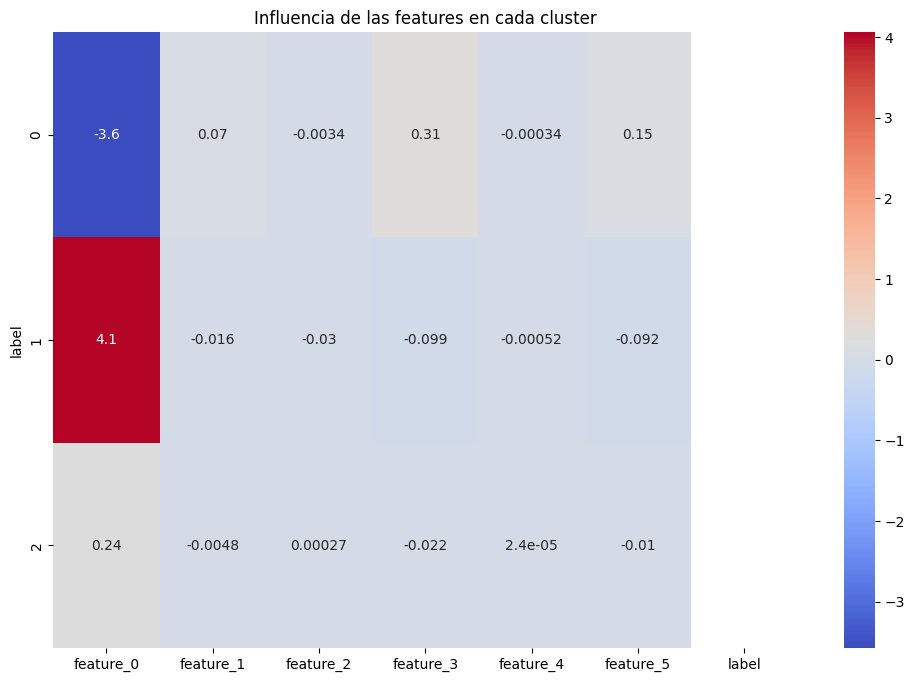

In [20]:
best_eps, best_min_samples = 0.8, 35
# Aplicar DBSCAN con los mejores parámetros encontrados
dbscan_model = DBSCAN(eps=best_eps, min_samples=best_min_samples)
y_dbscan = dbscan_model.fit_predict(X)

# Crear un DataFrame para clusters excluyendo el ruido
clusters_dbscan = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
clusters_dbscan['label'] = y_dbscan

# Excluir puntos de ruido
clusters_dbscan_valid = clusters_dbscan[clusters_dbscan['label'] != -1]

# Calcular las medias de las features para cada cluster
cluster_means = clusters_dbscan_valid.groupby('label').mean()

# Calcular la media global
global_mean = clusters_dbscan_valid.mean()

# Comparar las medias de cada cluster con la media global
influence = cluster_means - global_mean

# Mostrar la influencia de cada feature en cada cluster
print("Influencia de las features en cada cluster:")
print(influence)

# Visualización de la influencia de las features en cada cluster
plt.figure(figsize=(12, 8))
sns.heatmap(influence, annot=True, cmap='coolwarm')
plt.title('Influencia de las features en cada cluster')
plt.show()

In [21]:
# Calcular métricas de evaluación
silhouette_avg = silhouette_score(X, y_dbscan)
davies_bouldin_avg = davies_bouldin_score(X, y_dbscan)

# Imprimir métricas
print("Silhouette Score:", silhouette_avg)
print("Davies-Bouldin Index:", davies_bouldin_avg)
print("")

Silhouette Score: 0.9174875233921426
Davies-Bouldin Index: 1.5145251607349408



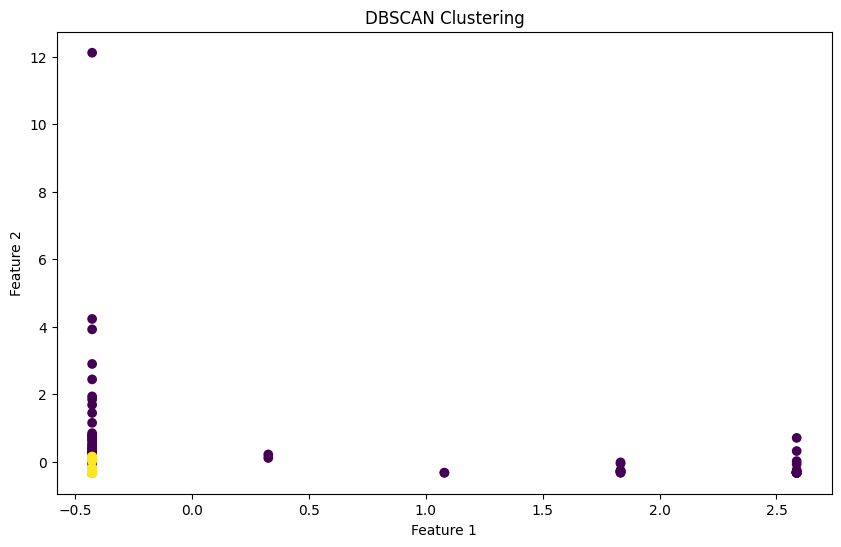

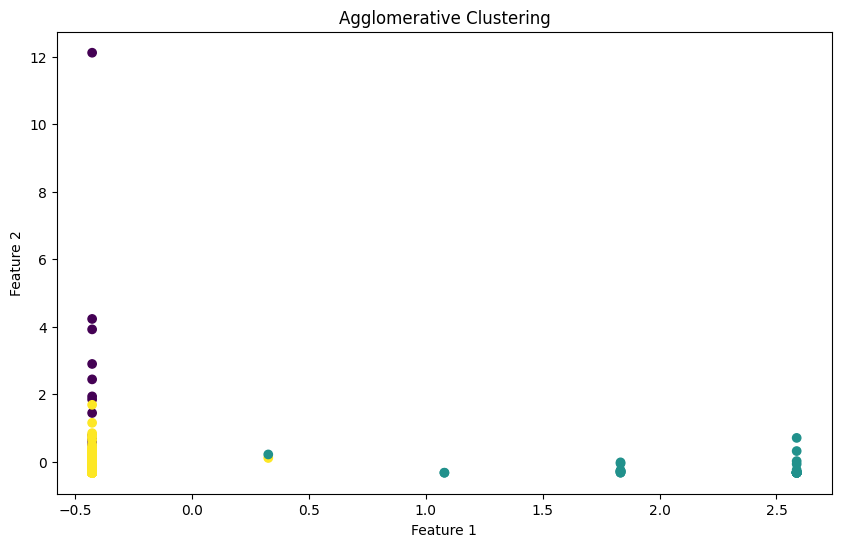

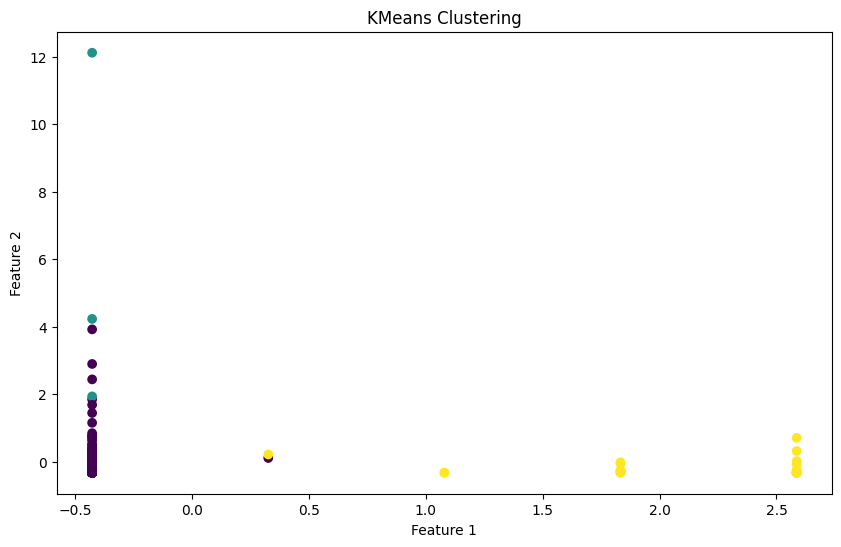

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Suponiendo que X es un DataFrame de pandas y labels son las etiquetas de los clusters obtenidas de cada algoritmo

# Visualización para DBSCAN
plt.figure(figsize=(10, 6))
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_dbscan, cmap='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Visualización para AgglomerativeClustering
plt.figure(figsize=(10, 6))
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_agg, cmap='viridis')
plt.title('Agglomerative Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Visualización para KMeans
plt.figure(figsize=(10, 6))
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_kmeans, cmap='viridis')
plt.title('KMeans Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

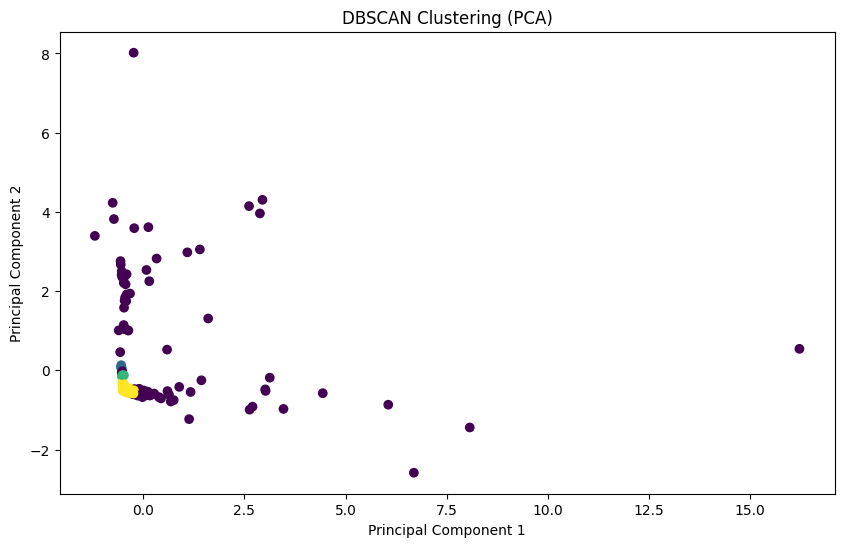

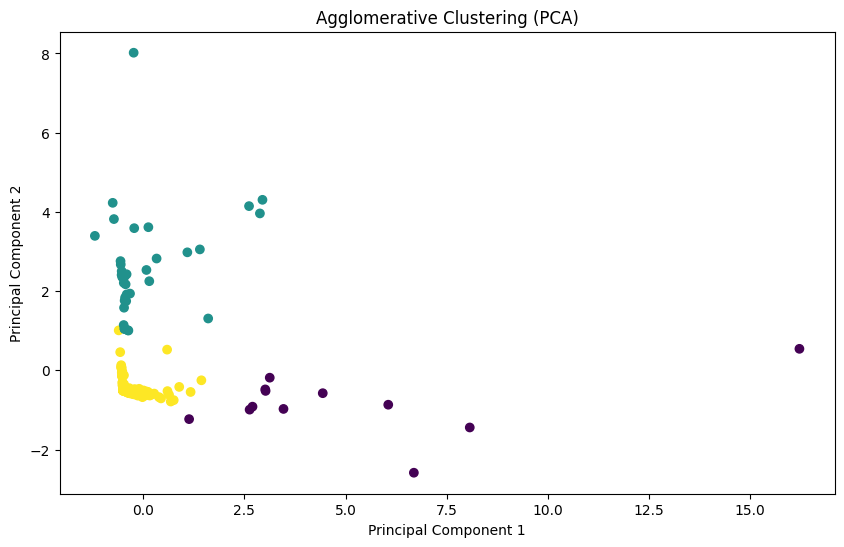

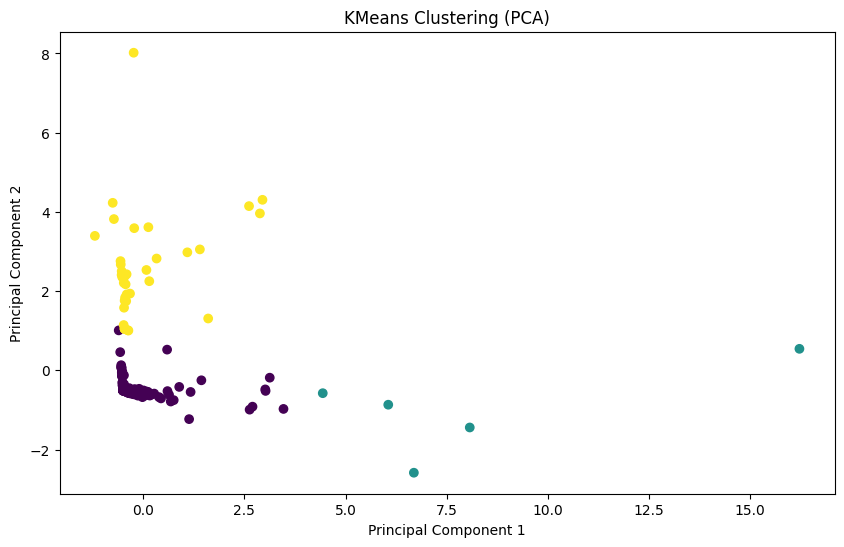

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Suponiendo que X es un DataFrame de pandas y labels son las etiquetas de los clusters obtenidas de cada algoritmo

# Aplicar PCA para reducir a 2 dimensiones
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Visualización para DBSCAN
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_dbscan, cmap='viridis')
plt.title('DBSCAN Clustering (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Visualización para AgglomerativeClustering
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_agg, cmap='viridis')
plt.title('Agglomerative Clustering (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Visualización para KMeans
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans, cmap='viridis')
plt.title('KMeans Clustering (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()